# Anomaly Detection Using Image Classification

###### - 01/06/16 by Austin Yu-Hung Chen 

### The most important task of my day jobs working in a IC design company
- To root-cause all the manufacturing bugs or failure so to productionize

### AlSO! It is an extreme frustration
- A manufacturing bug involves way more factors than a software bug
- A solution always takes serveral iterations(days~) before being justified

In [13]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

So... it comes to me if I can **Automate** to root cause an issue

And... as most engineers always do, I **Google Search**

And... I found **Convolutional Neural Network (CNN)** come to rescue

[PyTorch](https://pytorch.org/) -> [Fastai](https://www.fast.ai/) -> Fastai MOOC international fellowship
- with pytorch 1.0, I can **seamlessly** transitions between **research prototyping** and **production deployment**
- fastai is a **flexible** architecture to add state-of-the-art techniques
- both pytorch and fastai community **grows rapidly**

As always, let's get started with **Data Pipeline**

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
DATA_PATH = Config.data_path()
PATH = DATA_PATH/'anomaly'
PATH.ls()

[PosixPath('/home/achen/.fastai/data/anomaly/anomaly'),
 PosixPath('/home/achen/.fastai/data/anomaly/models'),
 PosixPath('/home/achen/.fastai/data/anomaly/normal')]

In [4]:
tfms = get_transforms(do_flip=False, max_zoom=1)

In [5]:
src = (ImageItemList.from_folder(PATH)
       .random_split_by_pct()
       .label_from_folder())

In [6]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

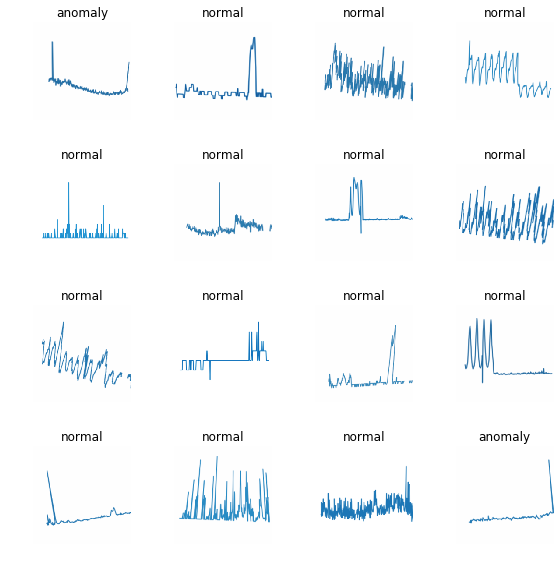

In [12]:
data.show_batch(rows=4, figsize=(8,8))

In [7]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (508 items)
[Category anomaly, Category anomaly, Category anomaly, Category anomaly, Category anomaly]...
Path: /home/achen/.fastai/data/anomaly
x: ImageItemList (508 items)
[Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224)]...
Path: /home/achen/.fastai/data/anomaly;

Valid: LabelList
y: CategoryList (126 items)
[Category anomaly, Category normal, Category normal, Category normal, Category normal]...
Path: /home/achen/.fastai/data/anomaly
x: ImageItemList (126 items)
[Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224)]...
Path: /home/achen/.fastai/data/anomaly;

Test: None

### Technique #1: Transfer Learning

As shown 2 slides ago, we only has **508** and **126** items for training set and validation set respectively. With such small amount of data, I am going to use a ***pre-trained*** [***resnet34***](https://arxiv.org/pdf/1512.03385.pdf) as my backbone and on top of it, we pile three fully connected layers with **dropout** and **batch norm**. 

In [14]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

### Technique #2: Learning Rate Finder

In [ ]:
learn.lr_find()

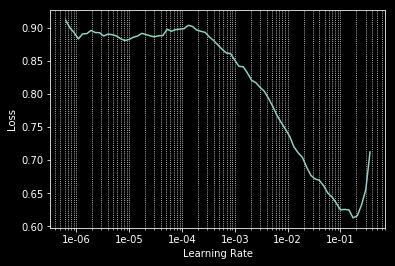

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

So...here I select `1e-2` as my learning rate

### Technique #3: [1-Cycle Policy](https://arxiv.org/abs/1708.07120)

In [ ]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,error_rate
1,0.761952,0.543574,0.246032
2,0.641019,0.687787,0.230159
3,0.522876,1.246816,0.246032
4,0.457442,0.530232,0.246032
5,0.423848,0.225621,0.071429
6,0.370040,0.232729,0.079365
7,0.335567,0.172647,0.055556
8,0.308068,0.158665,0.063492
9,0.287806,0.152856,0.063492
10,0.263615,0.147765,0.071429


In [ ]:
learn.plot_lr(mom=True)

Result interpretation...

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

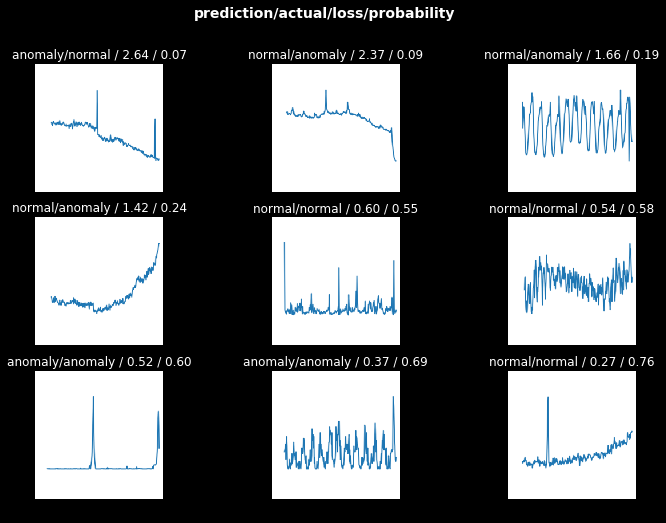

In [ ]:
interp.plot_top_losses(9, figsize=(12,8))

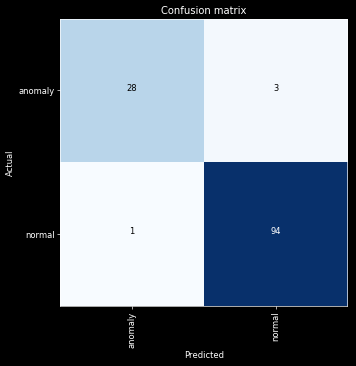

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

### Technique #4: Discriminative Learning Rates

![](tmp/heir_feat.png)

Futher training...
1. on the whole model **(backbone+head)**
2. with `lr=slice(1e-4)=[1e-4/9,1e-4/3,1e-4]` and 10 more epochs...

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


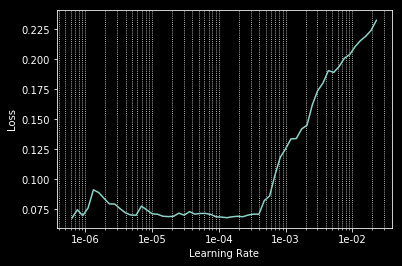

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
learn.fit_one_cycle(10, slice(1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.081575,0.092502,0.039683
2,0.071382,0.092599,0.039683
3,0.058237,0.094887,0.039683
4,0.052389,0.082674,0.031746
5,0.052574,0.085728,0.031746
6,0.060251,0.093697,0.039683
7,0.059458,0.097919,0.031746
8,0.061505,0.098460,0.039683
9,0.062167,0.104274,0.039683
10,0.061280,0.102488,0.039683


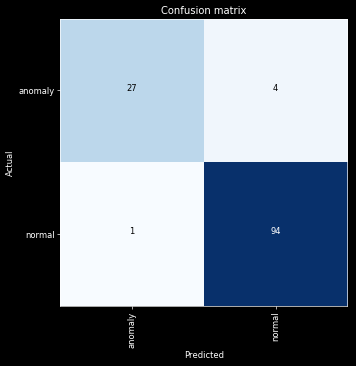

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Technique #5: Representability 

In [ ]:
DATA_PATH  = Path.home()/'.fastai/data/urban_sound8k'
AUDIO_PATH = DATA_PATH/'audio'
SPEC_PATH  = PATH = DATA_PATH/'spectro'
DATA_PATH.ls()

[PosixPath('/home/jupyter/.fastai/data/urban_sound8k/spectro'),
 PosixPath('/home/jupyter/.fastai/data/urban_sound8k/metadata_full.csv'),
 PosixPath('/home/jupyter/.fastai/data/urban_sound8k/metadata.csv'),
 PosixPath('/home/jupyter/.fastai/data/urban_sound8k/.DS_Store'),
 PosixPath('/home/jupyter/.fastai/data/urban_sound8k/metadata'),
 PosixPath('/home/jupyter/.fastai/data/urban_sound8k/audio'),
 PosixPath('/home/jupyter/.fastai/data/urban_sound8k/UrbanSound8K_README.txt'),
 PosixPath('/home/jupyter/.fastai/data/urban_sound8k/FREESOUNDCREDITS.txt')]

In [ ]:
folds = range(1, 11)
valid_fos = [1]
train_fos = list(set(folds) - set(valid_fos))
valid_fns = [fn.name for fo in valid_fos for fn in (PATH/f'fold{fo}').iterdir()]
train_fns = [fn.name for fo in train_fos for fn in (PATH/f'fold{fo}').iterdir()]

In [ ]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0,
                      max_lighting=0.0, max_warp=0.0, p_affine=0.0)

In [ ]:
pat = r"(\d*)-\d*-\d*.png$"
src = (ImageItemList.from_folder(PATH)
       .split_by_files(valid_fns)
       .label_from_re(pat=pat))

In [ ]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

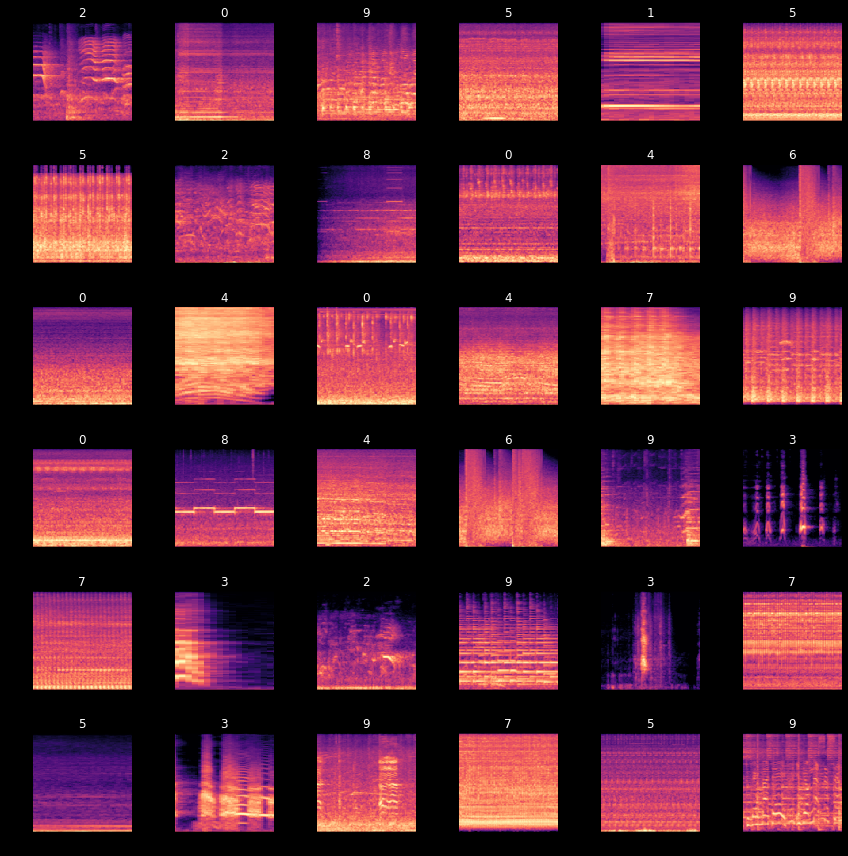

In [ ]:
data.show_batch(rows=4, figsize=(8,8))

### Technique #6: Pre-train with External Dataset 

The rule of thumb here is to find any open dataset that is similar to our target dataset

1. [FreeSound](https://www.freesound.org)
2. [Audioset](https://research.google.com/audioset/)

Repeat the previous techniques...

Final Result: **79.6%**

*In a sensibly organised society, if you improve productivity, there is room for everybody to benefit*
###### - **Geoffrey Hinton**

# **Q&A**